In [176]:
# Importing the necessary libraries
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 
import matplotlib.pyplot as plt 
from datetime import datetime
import plotly.express as px 
import missingno as msno
from psycopg2 import sql 
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import os 

# Data importation and Preprocessing 

In [177]:
# Getting the data and putting it in object "One_Acre_Fund_Metrics_and_Insights_data"
# Parsing dates as we retrieve the data to ensure accurate interpretation of date columns since the dates are stored in a non-standard format in the dataset
# Parsing dates this early in the process will increase processing time and ensure consistency when handling dates
One_Acre_Fund_Metrics_and_Insights_data = pd.read_csv(r"analytics_specialist_hiring_dataset_final_(2).csv", 
                                         parse_dates=["start_date", "end_date", "next_contract_payment_due_date", "birthdate"]
                                         )

In [221]:
# Creating a copy of the DataFrame to preserve original data integrity
# This ensures that any modifications made to the copied DataFrame do not affect the original data, providing a reliable reference point and saves time as we do not need to import the data every other time we run the code.
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,...,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears,payment_progression,expected_payment_progression_per_client,loan_type,gender_label
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,...,1.000000,2024-03-22,671,PAR90+,NaN,0.00,NaN,NaN,Cash Sale,Female
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,...,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16,0.627886,0.754315,Individual Loan,Male
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,...,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52,0.452432,0.769648,Individual Loan,Male
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,...,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35,0.416194,0.587680,Individual Loan,Male
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,...,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68,0.335869,0.753873,Individual Loan,Male


In [179]:
# Unifying all the naming conventions to ensure code consistency and maintainability:
One_Acre_Fund_Metrics_and_Insights_data.columns = One_Acre_Fund_Metrics_and_Insights_data.columns.str.lower()
One_Acre_Fund_Metrics_and_Insights_data.columns

Index(['contract_reference', 'status', 'start_date', 'end_date',
       'next_contract_payment_due_date', 'cumulative_amount_paid',
       'expected_cumulative_amount_paid', 'nominal_contract_value',
       'deposit_amount', 'birthdate', 'gender', 'l3_entity_id', 'name',
       'expected_payment_progression'],
      dtype='object')

In [222]:
# Data to be used in the database
One_Acre_Fund_Metrics_and_Insights_dta = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [180]:
# Checking Orientation of the data 
One_Acre_Fund_Metrics_and_Insights_data.shape

(1000, 14)

In [181]:
# Checking for concise summary information about the DataFrame's structure and content                     
One_Acre_Fund_Metrics_and_Insights_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   contract_reference               1000 non-null   object        
 1   status                           1000 non-null   object        
 2   start_date                       1000 non-null   datetime64[ns]
 3   end_date                         246 non-null    object        
 4   next_contract_payment_due_date   1000 non-null   datetime64[ns]
 5   cumulative_amount_paid           1000 non-null   float64       
 6   expected_cumulative_amount_paid  1000 non-null   float64       
 7   nominal_contract_value           1000 non-null   float64       
 8   deposit_amount                   1000 non-null   float64       
 9   birthdate                        858 non-null    object        
 10  gender                           1000 non-null   int64       

In [182]:
#Checking for Missing values in the data
One_Acre_Fund_Metrics_and_Insights_data.isnull().sum()

contract_reference                   0
status                               0
start_date                           0
end_date                           754
next_contract_payment_due_date       0
cumulative_amount_paid               0
expected_cumulative_amount_paid      0
nominal_contract_value               0
deposit_amount                       0
birthdate                          142
gender                               0
l3_entity_id                         0
name                                 0
expected_payment_progression         0
dtype: int64

*The end_date column has significant amount of missing data i.e more than 75% and also we have missing values in birthdate column about 14%*

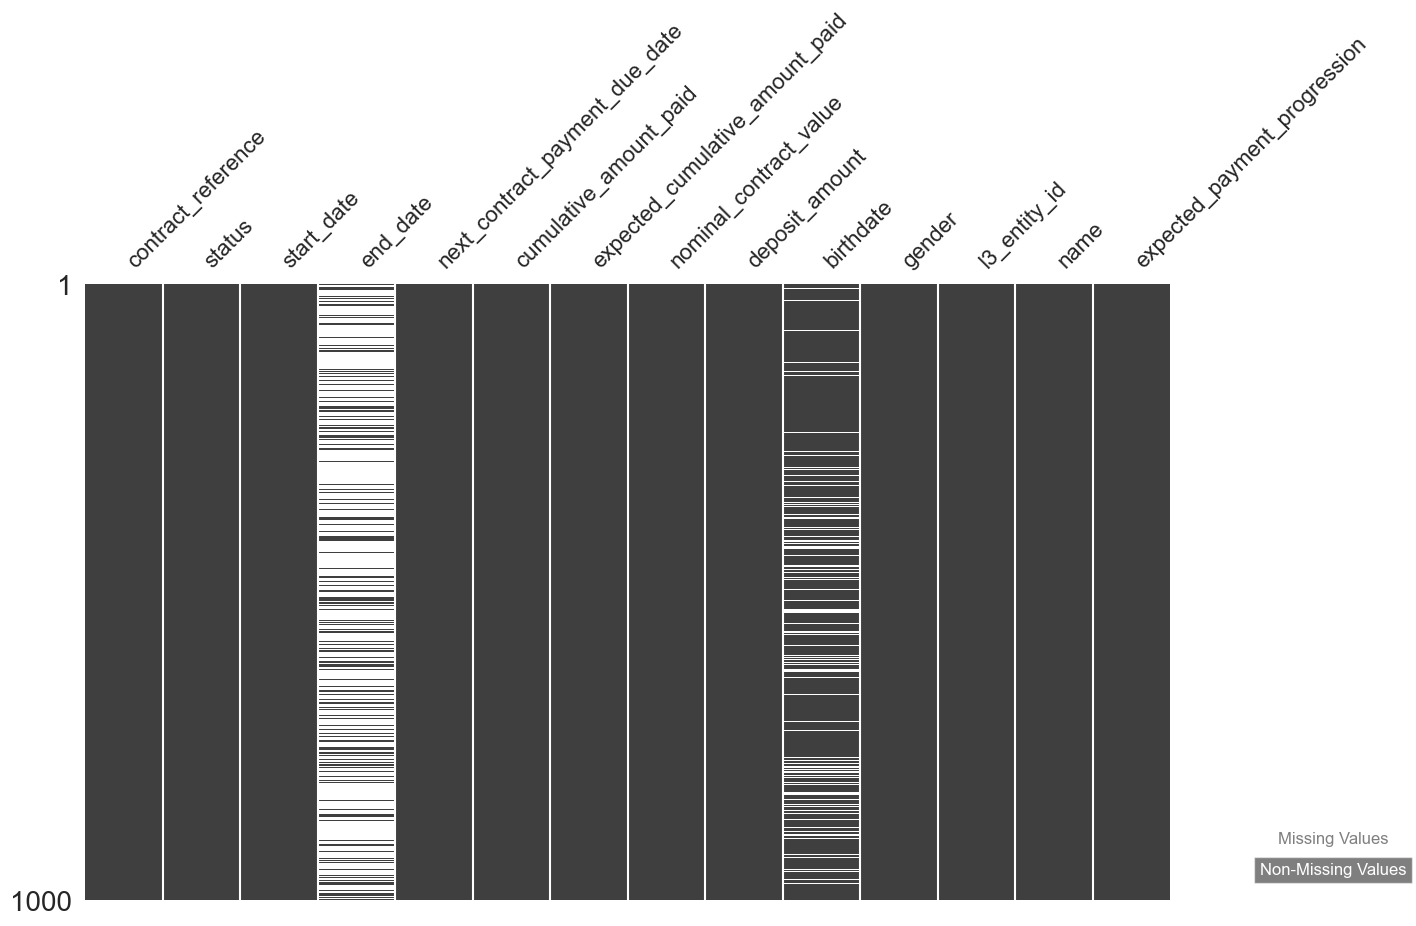

In [183]:
# Visualizing missing values
fig, ax = plt.subplots(figsize=(14, 8))
msno.matrix(One_Acre_Fund_Metrics_and_Insights_data,ax = ax,sparkline = False)
plt.text(1.15, 0.05, 'Non-Missing Values', color = 'white', ha ='center', va = 'center', transform = ax.transAxes, fontsize = 12, bbox = dict(facecolor= 'black', alpha = 0.5))
plt.text(1.15, 0.1, 'Missing Values', color = 'grey', ha='center', va = 'center', transform = ax.transAxes, fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

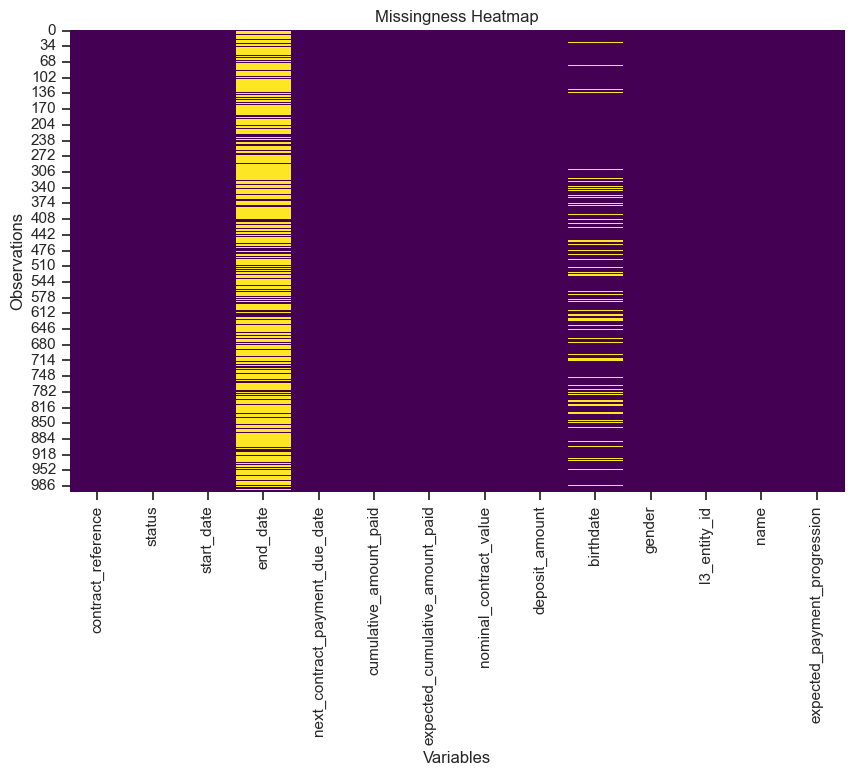

In [184]:
# Checking whether the missingness in the data is occuring at random or not
plt.figure(figsize = (10, 6))
sns.heatmap(One_Acre_Fund_Metrics_and_Insights_data.isnull(), cmap = 'viridis', cbar = False)
plt.title('Missingness Heatmap')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.show()

*There is no pattern to the missingness of the data, this means that the Missingness is Occuring at Random (MAR)*

## Dealing with Missing Data

#### Dropping **end_date** since it has more than 75% missing entries and is therefore considered to lack sufficient data integrity and imputing them might therefore introduce unnecesary noise

In [185]:
# Defining a threshold for missing values and Dropping columns with more than 75% missing values
missing_threshold = 0.75 

# Calculating  the percentage of missing values for each column
missing_percentage = (One_Acre_Fund_Metrics_and_Insights_data.isnull().sum() / len(One_Acre_Fund_Metrics_and_Insights_data)).sort_values(ascending = False)

# Identifying columns to drop based on the threshold
columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index

# Dropping columns with a high percentage of missing values
One_Acre_Fund_Metrics_and_Insights_data.drop(columns = columns_to_drop, inplace = True)

In [186]:
# Imputing missing birthdates with "unknown" to preserve data integrity and privacy, ensuring transparency while maintaining dataset usability.
One_Acre_Fund_Metrics_and_Insights_data['birthdate'].fillna('unknown', inplace = True)

# **TASK 1**

### PAR Status

In [187]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous dataframe
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

# Today's date
One_Acre_Fund_Metrics_and_Insights_data['today'] = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))  

# Calculating the difference between the next contract payment due date and today's date  to determine the days past due
One_Acre_Fund_Metrics_and_Insights_data['days_past_due'] = (One_Acre_Fund_Metrics_and_Insights_data['today'] - One_Acre_Fund_Metrics_and_Insights_data['next_contract_payment_due_date']).dt.days

# Defining a function assign_par_status that assigns appropriate  the appropriate PAR Status based on the days past due
def assign_par_status(days_past_due):
    if days_past_due > 90:
        return 'PAR90+'
    elif days_past_due > 30:
        return 'PAR31-90'
    elif days_past_due > 7:
        return 'PAR8-30'
    elif days_past_due >= 0:
        return 'PAR0-7'
    else:
        return 'On Time'

# Creating a new column labeled 'PAR status' and populating it with the assigned PAR Status
One_Acre_Fund_Metrics_and_Insights_data['PAR_status'] = One_Acre_Fund_Metrics_and_Insights_data['days_past_due'].apply(assign_par_status)
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression,today,days_past_due,PAR_status
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315,2024-03-22,568,PAR90+
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648,2024-03-22,608,PAR90+
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,5084,Individual loan,0.587680,2024-03-22,581,PAR90+
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873,2024-03-22,626,PAR90+


### Current Collection Rate

In [188]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous DataFrame
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [189]:
# Extracting relevant columns from the dataset
cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['cumulative_amount_paid']
expected_cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['expected_cumulative_amount_paid']
deposit_amount = One_Acre_Fund_Metrics_and_Insights_data['deposit_amount']

# Calculating Current Collection Rate
current_collection_rate = cumulative_amount_paid / (expected_cumulative_amount_paid - deposit_amount)

# Adding Current Collection Rate as a new column to the DataFrame
One_Acre_Fund_Metrics_and_Insights_data['current_collection_rate'] = current_collection_rate
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,5084,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935


### Total Arrears Per Client

In [190]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous DataFrame
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [191]:
# Extracting relevant columns
expected_cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['expected_cumulative_amount_paid']
cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['cumulative_amount_paid']

# Deriving each client's total amount in arrears
total_amount_in_arrears = expected_cumulative_amount_paid - cumulative_amount_paid

# Adding a column 'amount_in_arrears' to the DataFrame
One_Acre_Fund_Metrics_and_Insights_data['total_amount_in_arrears'] = total_amount_in_arrears
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN,0.00
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,5084,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68


Since the Data Dictionary states that  **A client can have multiple contracts:**  
In a situation where a client has more than one contract reference we would have needed to aggregate it per client identifier(Contract Reference) so as to get their (Clients) Totals in arreas

`total_amount_in_arrears_per_client = total_amount_in_arrears.groupby('contract_reference')['total_amount_in_arrears].sum().reset_index()
`

### Payment Progression Per Client

In [192]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous DataFrame
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [193]:
# Extracting relevant columns for payment progression per client
cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['cumulative_amount_paid']
nominal_contract_value = One_Acre_Fund_Metrics_and_Insights_data['nominal_contract_value']

# Calculating Payment Progression for each client
payment_progression = cumulative_amount_paid / nominal_contract_value

# Adding 'payment_progression' as a new column to the DataFrame
One_Acre_Fund_Metrics_and_Insights_data['payment_progression'] = payment_progression
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears,payment_progression
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN,0.00,NaN
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16,0.627886
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52,0.452432
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,5084,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35,0.416194
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68,0.335869


### Expected Payment Progression Per Client

In [194]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous DataFrame
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [195]:
# Extracting relevant columns for Expected Payment Progression Per Client
expected_cumulative_amount_paid = One_Acre_Fund_Metrics_and_Insights_data['expected_cumulative_amount_paid']
nominal_contract_value = One_Acre_Fund_Metrics_and_Insights_data['nominal_contract_value']

# Calculating Expected Payment Progression for each client
expected_payment_progression_per_client = expected_cumulative_amount_paid / nominal_contract_value

# Adding 'expected_payment_progression_per_client' as a new column to the DataFrame
One_Acre_Fund_Metrics_and_Insights_data['expected_payment_progression_per_client'] = expected_payment_progression_per_client
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears,payment_progression,expected_payment_progression_per_client
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN,0.00,NaN,NaN
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16,0.627886,0.754315
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52,0.452432,0.769648
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,5084,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35,0.416194,0.587680
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68,0.335869,0.753873


### Deriving Loan Types

In [196]:
# This ensures that any modifications made to the copied DataFrame do not affect the previous DataFrame
One_Acre_Fund_Metrics_and_Insights_data = One_Acre_Fund_Metrics_and_Insights_data.copy()

In [197]:
# Creating a new column 'loan_type' based on names in the 'name' column 
One_Acre_Fund_Metrics_and_Insights_data['loan_type'] = One_Acre_Fund_Metrics_and_Insights_data['name'].apply(lambda x: 'Individual Loan' if 'Individual' in x
                                        else ('Group Loan' if 'Group' in x
                                              else ('Paygo Loan' if 'Paygo' in x
                                                    else ('Cash Sale' if 'Cash' in x
                                                          else x))))
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,...,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears,payment_progression,expected_payment_progression_per_client,loan_type
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,...,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN,0.00,NaN,NaN,Cash Sale
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,...,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16,0.627886,0.754315,Individual Loan
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,...,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52,0.452432,0.769648,Individual Loan
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,...,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35,0.416194,0.587680,Individual Loan
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,...,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68,0.335869,0.753873,Individual Loan


# **TASK 2**

### The results of task 2 will be in an SQL file named **TASK_2_Results.sql** 

### Creating PostgreSQL database table and Populating it with data using Python's library **psycopg2**

In [198]:
# Innitial columns to use to build the database
One_Acre_Fund_Metrics_and_Insights_data_to_sql = One_Acre_Fund_Metrics_and_Insights_dta[['contract_reference', 'status', 'start_date', 'end_date',
       'next_contract_payment_due_date', 'cumulative_amount_paid',
       'expected_cumulative_amount_paid', 'nominal_contract_value',
       'deposit_amount', 'birthdate', 'gender', 'l3_entity_id', 'name',
       'expected_payment_progression']]
One_Acre_Fund_Metrics_and_Insights_data_to_sql.head()

,contract_reference,status,start_date,end_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,l3_entity_id,name,expected_payment_progression
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20T08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,5121,Cash Sales IPP,1.000000
1,abc0002,Active,2022-05-25 13:28:49.873746,NaN,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,5073,Individual loan,0.754315
2,abc0003,Active,2022-05-31 10:02:23.158972,NaN,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,5072,Individual loan,0.769648
3,abc0004,Active,2022-07-05 11:49:03.801563,NaN,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,NaN,1,5084,Individual loan,0.587680
4,abc0005,Active,2022-05-31 06:31:25.977374,NaN,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,5074,Individual loan,0.753873


In [199]:
# Securing the database password through abstraction
password = input("Please enter your Password: ") 

In [200]:
# Establishing a connection to the Database
conn = psycopg2.connect(
    host = "localhost",
    port = "5432",
    database = "One_Acre_Fund_Task_Data",
    user = "postgres",
    password = password)
conn

<connection object at 0x000001DF1D933BC0; dsn: 'user=postgres password=xxx dbname=One_Acre_Fund_Task_Data host=localhost port=5432', closed: 0>

In [201]:
# Setting the isolation level to autocommit 
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [202]:
# Creating a cursor object
cursor = conn.cursor() 

In [203]:
# Defining the table name
table_name = 'One_Acre_Fund_Data' 

In [204]:
# Defining  CREATE TABLE statement to help with table creation
create_table_query = sql.SQL('''
    CREATE TABLE IF NOT EXISTS {} (
        "contract_reference" VARCHAR(255),
        "status" VARCHAR(255),
        "start_date" TIMESTAMP,
        "end_date" TIMESTAMP,                    
        "next_contract_payment_due_date" TIMESTAMP,
        "cumulative_amount_paid" DECIMAL(10, 2),                   
        "expected_cumulative_amount_paid" DECIMAL(10, 2),
        "nominal_contract_value" DECIMAL(10, 2),            
        "deposit_amount" DECIMAL(10, 2),
        "birthdate" DATE,
        "gender" BOOLEAN,
        "l3_entity_id" INTEGER,
        "name" VARCHAR(255),
        "expected_payment_progression" DECIMAL
    )
''').format(sql.Identifier(table_name))

In [205]:
# Executing the CREATE TABLE statement
cursor.execute(create_table_query) 

In [206]:
# Defining the path to the CSV file
csv_file_path = 'C:\\Users\\Ernest\Desktop\\Python\\One Acre Fund THT\\analytics_specialist_hiring_dataset_final_(2).csv'

# Defining the COPY command to load data from CSV
copy_command = sql.SQL('COPY {} FROM STDIN WITH (FORMAT CSV, DELIMITER ",", HEADER)').format(
    sql.Identifier(table_name)
)
# Executing the COPY command with the CSV file path
with open(csv_file_path, 'r') as f:
    cursor.copy_expert(copy_command, f)

# Commiting the changes
conn.commit()

In [207]:
# Closing the cursor and the database connection to ensure proper resource management
cursor.close()
conn.close()

# **TASK 3**

## Exploratory Data Analysis (EDA)

In [208]:
# Checking Orientation of the data 
One_Acre_Fund_Metrics_and_Insights_data.describe()

,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,gender,l3_entity_id,expected_payment_progression,today,days_past_due,current_collection_rate,total_amount_in_arrears,payment_progression,expected_payment_progression_per_client
count,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000.000000,916.000000,1000.000000,916.000000,916.000000
mean,2022-04-04 08:28:33.680826112,2022-08-22 07:02:57.770271744,6400.140290,8275.865090,9459.535900,2637.467100,0.630000,5113.506000,0.861177,2024-03-22 00:00:00,577.180000,inf,1875.724800,0.662067,0.848446
min,2022-01-12 13:14:07.157989,2022-01-27 07:45:50.446466,0.000000,0.000000,0.000000,0.000000,0.000000,5072.000000,0.000000,2024-03-22 00:00:00,-32715.000000,-3.527567,-14396.000000,0.000000,0.000000
25%,2022-02-27 07:26:39.621111552,2022-05-25 15:00:59.097382656,2500.000000,3831.800000,5110.765000,1271.000000,0.000000,5121.000000,0.774546,2024-03-22 00:00:00,550.000000,0.874724,0.000000,0.422491,0.761294
50%,2022-03-10 07:27:56.173650176,2022-07-19 04:32:49.341385472,5500.000000,7144.780000,8171.860000,2157.000000,1.000000,5121.000000,0.992899,2024-03-22 00:00:00,611.000000,1.219132,796.450000,0.662455,0.946997
75%,2022-04-09 20:35:56.319520256,2022-09-18 03:59:25.873050112,9562.500000,12807.737500,13465.640000,4000.000000,1.000000,5121.000000,1.000000,2024-03-22 00:00:00,666.000000,1.443264,3149.250000,0.929418,1.000000
max,2022-09-22 08:29:53.208525,2113-10-16 08:10:41.892858,23982.870000,23854.140000,24009.140000,9598.000000,1.000000,5121.000000,1.000000,2024-03-22 00:00:00,784.000000,inf,16556.140000,1.000000,1.000000
std,NaN,NaN,4970.486189,5631.984333,5814.130836,1932.014412,0.483046,15.894609,0.192499,NaN,1056.694555,NaN,3053.248041,0.263818,0.196281


*The mean is higher than the median indicating that the data is positively skewed, data being skewed in most cases might mean that there are  **Outliers***



### Outlier Detection

<Axes: >

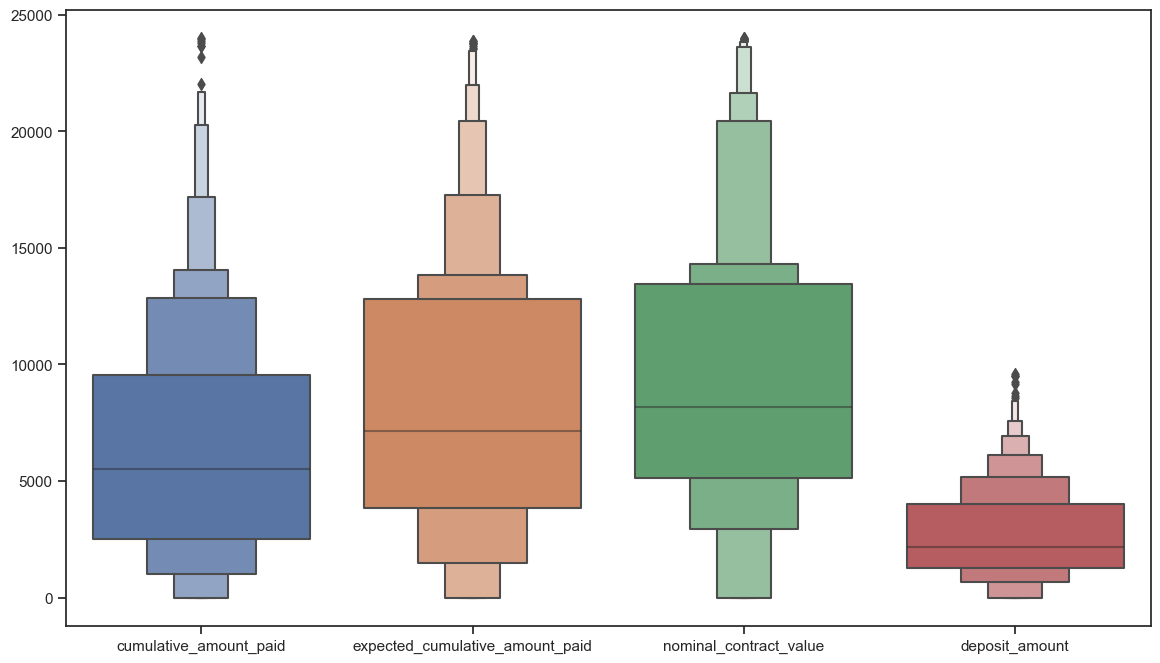

In [209]:
# Visualizing potential outliers in relevant features using boxen plots
plt.figure(figsize=(14, 8))

sns.boxenplot(data=One_Acre_Fund_Metrics_and_Insights_data
              [['cumulative_amount_paid', 'expected_cumulative_amount_paid', 
                'nominal_contract_value', 'deposit_amount']])

* *The data exhibits **outliers**, which is evident from the skewed distribution towards the right.*
* *Outliers can sometimes represent valid data points that merit further investigation. For example, they may indicate fraudulent activities or other  patterns which are noteworthy.*
* *In cases where outliers stem from data entry errors, it's crucial to address them. Imputing outliers with the mean helps preserve the sample size and mitigate bias.*


In [210]:
# Using mean to fix the outliers
# Defining a function to impute outliers with the mean
def outliers_mean_imputer(column):
    mean = column.mean()
    std_dev = column.std()
    threshold = 3  # [3 standard deviations]
    
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
     
    # Using .loc to modify the original DataFrame to avoid "SettingWithCopyWarning" error
    One_Acre_Fund_Metrics_and_Insights_data.loc[column < lower_bound, column.name] = mean
    One_Acre_Fund_Metrics_and_Insights_data.loc[column > upper_bound, column.name] = mean

# Imputing outliers with the mean for each column
columns_to_impute = ['cumulative_amount_paid', 'expected_cumulative_amount_paid', 'nominal_contract_value', 'deposit_amount']
for column_name in columns_to_impute:
    outliers_mean_imputer(One_Acre_Fund_Metrics_and_Insights_data[column_name])
One_Acre_Fund_Metrics_and_Insights_data.head()

,contract_reference,status,start_date,next_contract_payment_due_date,cumulative_amount_paid,expected_cumulative_amount_paid,nominal_contract_value,deposit_amount,birthdate,gender,...,name,expected_payment_progression,today,days_past_due,PAR_status,current_collection_rate,total_amount_in_arrears,payment_progression,expected_payment_progression_per_client,loan_type
0,abc0001,Completed,2022-05-20 08:23:51.406303,2022-05-20 08:23:51.406303,0.0,0.00,0.00,0.0,1943-01-01,0,...,Cash Sales IPP,1.000000,2024-03-22,671,PAR90+,NaN,0.00,NaN,NaN,Cash Sale
1,abc0002,Active,2022-05-25 13:28:49.873746,2022-08-31 18:34:01.654276,5131.0,6164.16,8171.86,2000.0,1937-01-01,1,...,Individual loan,0.754315,2024-03-22,568,PAR90+,1.232181,1033.16,0.627886,0.754315,Individual Loan
2,abc0003,Active,2022-05-31 10:02:23.158972,2022-07-22 01:17:15.526819,3100.0,5273.52,6851.86,2000.0,1963-11-10,1,...,Individual loan,0.769648,2024-03-22,608,PAR90+,0.946993,2173.52,0.452432,0.769648,Individual Loan
3,abc0004,Active,2022-07-05 11:49:03.801563,2022-08-18 13:34:13.983433,4350.0,6142.35,10451.86,3000.0,unknown,1,...,Individual loan,0.587680,2024-03-22,581,PAR90+,1.384314,1792.35,0.416194,0.587680,Individual Loan
4,abc0005,Active,2022-05-31 06:31:25.977374,2022-07-04 13:30:36.436593,3450.0,7743.68,10271.86,2500.0,1998-05-10,1,...,Individual loan,0.753873,2024-03-22,626,PAR90+,0.657935,4293.68,0.335869,0.753873,Individual Loan


* *The outliers have been removed*

## Numerical variables

In [211]:
numerical_columns = ['cumulative_amount_paid', 'expected_cumulative_amount_paid', 'nominal_contract_value', 'deposit_amount']

### Scatterplots

C:\Users\Ernest\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


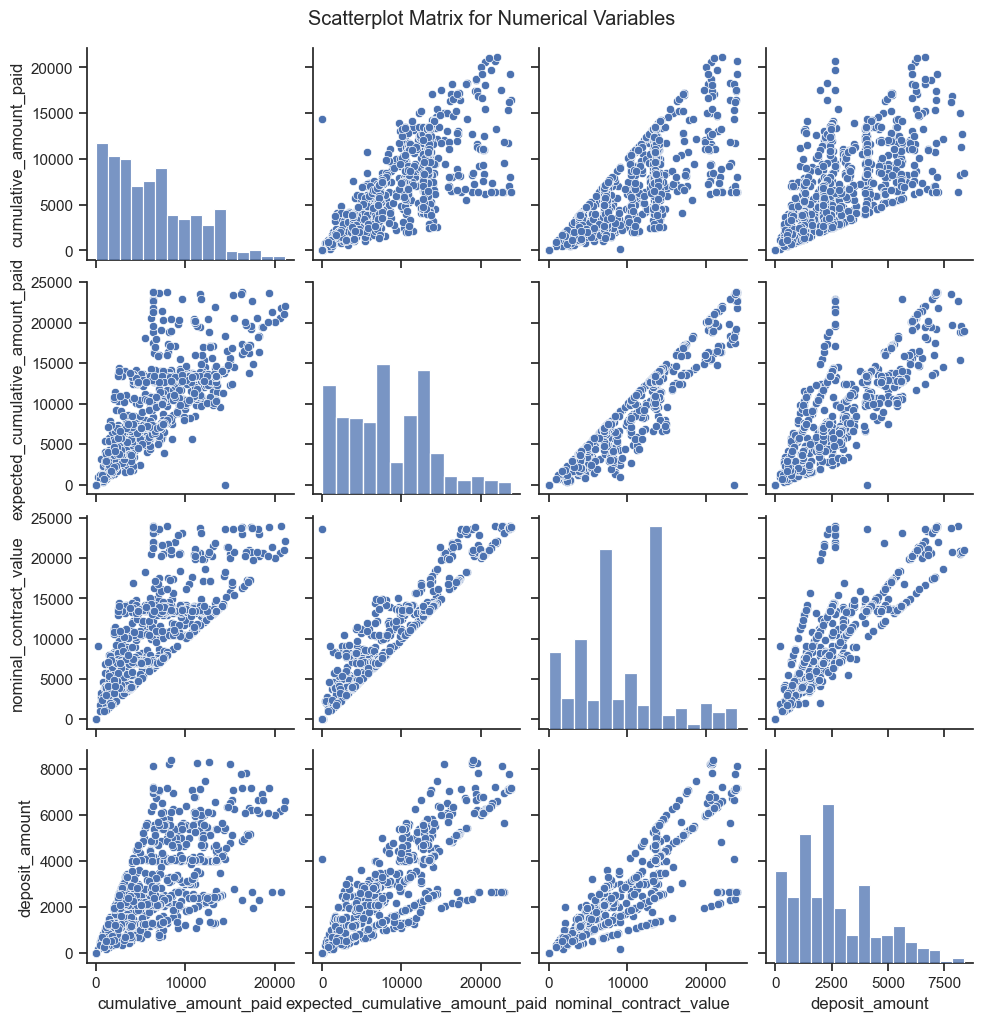

In [212]:
# Creating scatterplot matrix
sns.set(style = "ticks")
scatterplot_matrix = sns.pairplot(One_Acre_Fund_Metrics_and_Insights_data[numerical_columns])
scatterplot_matrix.fig.suptitle('Scatterplot Matrix for Numerical Variables', y = 1.02)
plt.show()

**There is positive correlation between**

* *cummulative amount paid and deposit_amount*
* *cummulative amount paid and nominal_contract_value*
* *cummulative amount paid and expected_cummulative_amount_paid*
* *expected_cummulative_amount_paid and deposit_amount*
* *expected_cummulative_amount_paid and nominal_contract_value*
* *nominal_contract_value and deposit_amount*

### Distribution of clients by Region

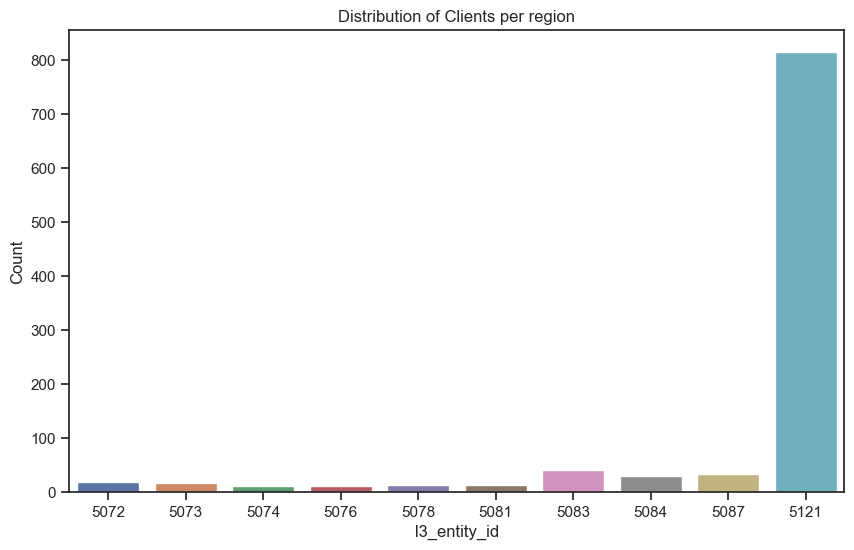

In [213]:
# Creating a count plot
plt.figure(figsize = (10, 6))
sns.countplot(x = One_Acre_Fund_Metrics_and_Insights_data.l3_entity_id)
plt.title('Distribution of Clients per region')
plt.xlabel('l3_entity_id')
plt.ylabel('Count')
plt.show()

* *Region 5121 has the biggest enrollment of clients, it is a good idea to deploy more resources in this area and also attempt to figure out what has brought about this success and apply the same to areas with less enrollments*

### Disribution by Gender

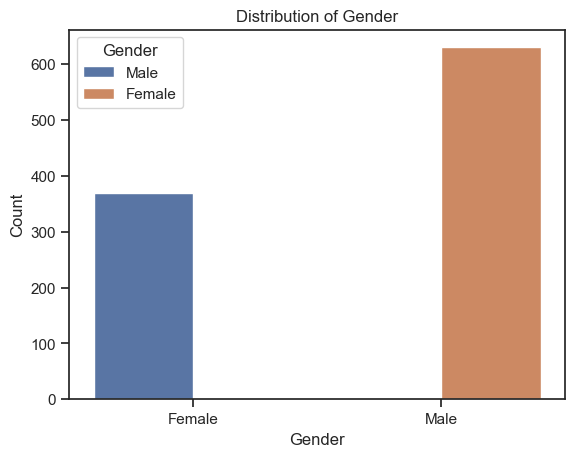

In [214]:
# Mapping gender categories to labels
gender_labels = {1: 'Male', 0: 'Female'}

# Creating a new column with gender labels
One_Acre_Fund_Metrics_and_Insights_data['gender_label'] = One_Acre_Fund_Metrics_and_Insights_data['gender'].map(gender_labels)

# Creating count plot
sns.countplot(data = One_Acre_Fund_Metrics_and_Insights_data, x = 'gender_label', hue = 'gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title = 'Gender', labels = ['Male', 'Female'])
plt.show()

* *There are far much fewer female entries (370) compared to Male entries (630)*

### Disribution by Loan types

In [215]:
# percentage distribution
One_Acre_Fund_Metrics_and_Insights_data.loan_type.value_counts(normalize = True)*100

loan_type
Group Loan                                              56.3
Individual Loan                                         35.2
Cash Sale                                                8.4
Biolite Home System PayGo-Enabled - PayGo Loan - IPP     0.1
Name: proportion, dtype: float64

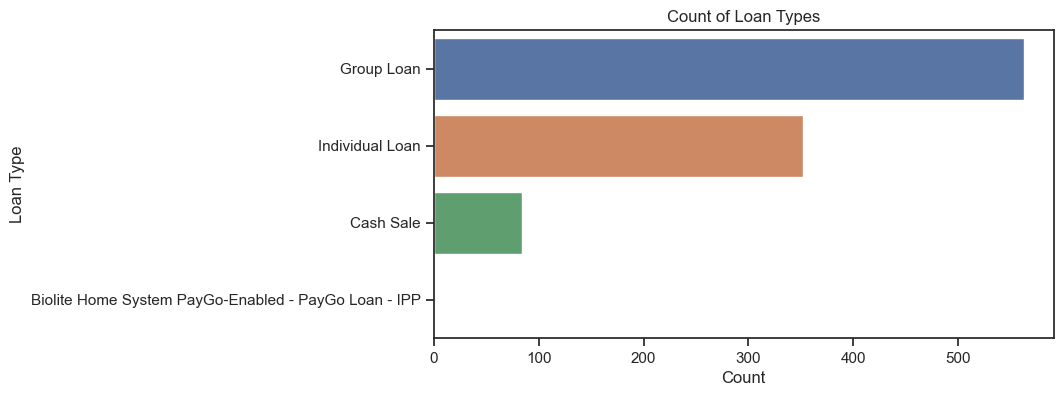

In [216]:
# loan_types counts
loan_types = One_Acre_Fund_Metrics_and_Insights_data.loan_type.value_counts()

# barchart
plt.figure(figsize = (8, 4 ))
sns.barplot(x = loan_types.values, y=loan_types.index, orient = 'h')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Loan Type')
plt.title('Count of Loan Types')
plt.show()

**The highest loan type is Group loan (56.3%) followed by Individual Loan (35.2%). Cash Sale and Biolite Home System PayGo-Enabled - PayGo Loan - IPP was the lowest with 8.4% and 0.1%*

### Top 10 Contracts per Clients

In [217]:
# Grouping by contract reference and suming the metrics
Client_contracts = One_Acre_Fund_Metrics_and_Insights_data.groupby('contract_reference')[['cumulative_amount_paid']].sum().reset_index()

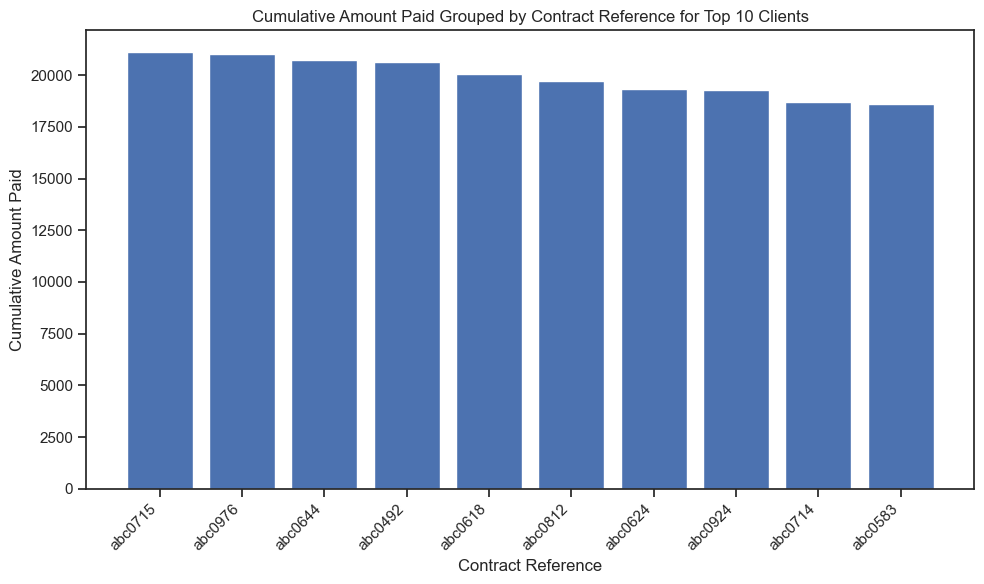

In [218]:
# Getting top 10 clients based on cumulative amount paid
top_10_clients = Client_contracts.nlargest(10, 'cumulative_amount_paid')

# Plotting bar plot to visualize this 

plt.figure(figsize = (10, 6))
plt.bar(top_10_clients['contract_reference'], top_10_clients['cumulative_amount_paid'])
plt.xlabel('Contract Reference')
plt.ylabel('Cumulative Amount Paid')
plt.title('Cumulative Amount Paid Grouped by Contract Reference for Top 10 Clients')
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()
plt.show()


* *The Client with contract_reference **abc0715** has the Highest cumulative_amount_paid*

In [219]:
One_Acre_Fund_Metrics_and_Insights_data.columns

Index(['contract_reference', 'status', 'start_date',
       'next_contract_payment_due_date', 'cumulative_amount_paid',
       'expected_cumulative_amount_paid', 'nominal_contract_value',
       'deposit_amount', 'birthdate', 'gender', 'l3_entity_id', 'name',
       'expected_payment_progression', 'today', 'days_past_due', 'PAR_status',
       'current_collection_rate', 'total_amount_in_arrears',
       'payment_progression', 'expected_payment_progression_per_client',
       'loan_type', 'gender_label'],
      dtype='object')

### **Exporting The Processed/Wrangled Data For Further Visualization and Report Building In Bi Tools(Power Bi/Tableau/QuickSight)**

In [220]:
One_Acre_Fund_Metrics_and_Insights_data[['contract_reference', 'status', 'start_date',
       'next_contract_payment_due_date', 'cumulative_amount_paid',
       'expected_cumulative_amount_paid', 'nominal_contract_value',
       'deposit_amount', 'birthdate', 'gender', 'l3_entity_id', 'name',
       'expected_payment_progression', 'today', 'days_past_due', 'PAR_status',
       'current_collection_rate', 'total_amount_in_arrears',
       'payment_progression', 'expected_payment_progression_per_client',
       'loan_type', 'gender_label']].to_csv("Cleaned_One_Acre_Fund_Metrics_and_Insights_data.csv")
